In [2]:
import json
import os
from pathlib import Path
from itertools import permutations

import joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, welch
from scipy.stats import skew, kurtosis, pearsonr

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import (
    GroupShuffleSplit,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier



In [2]:
## Mauvaise prediction de la classe 1 pour l'instant
## Regarder pour scaler les trucs pour chaque signal et pas accros tout les samples 
## Cyp affirme que le choix du model et des parametre ne devrait pas faire autant de diff avec le top du leaderbord, c'est qu il nous faut des meilleur feature
## Donne code + papier d'edunao a claude et ameliorer les features
## Utilisation quand on cree les features, je sais pas si y a pas possiblement du dataleakage (mais cela ne devrait pas impacter quand on entraine sur tout le dataset pour la submission)
## Une piste pourrait etre d'utiliser un des 7 signaux (individu) comme test set, parce je crois que la on overfit peut etre trop aux individus que nous on a (et qui ne sont pas dans le test set )

In [3]:
# Set up global variables

# Base directory containing the Kaggle bundle and model outputs.
# BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025")
# BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025")  
BUNDLE_DIR = Path(r"C:\Users\Adrien\Documents\Dossier_dev\scripts\Kaggle_beacon_biosignals_ML")
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\Adrien\Documents\Dossier_dev\scripts\Kaggle_beacon_biosignals_ML


## Load Data and Create Features

In [ ]:
# Load data and store it in simple dataframe

def load_data(path):
    signals = {}
    for root, _, files in os.walk(path):
        for file in sorted(files):  # Sort for consistency
            file_path = os.path.join(root, file)
            # Extract the actual signal number from filename (e.g., "signal_8.npy" -> 8)
            signal_num = int(file.split('_')[-1].split('.')[0])
            signals[signal_num] = np.load(file_path)
    return signals

def format_data(train):
    # Define base columns
    base_columns = ['captor_0', 'captor_1', 'captor_2', 'captor_3', 'captor_4', 'num_epoch', 'num_signal']
    
    # Add target column only for training data
    if train:
        columns = base_columns.copy()
        columns.insert(5, 'target')  # Insert target at position 5 (after captors, before num_epoch)
        signals = load_data('signals_train')
        targets = load_data('targets_train')
    else:
        columns = base_columns
        signals = load_data('signals_test')
    
    main_df = pd.DataFrame(columns=columns)

    for signal_idx in signals.keys():
        signal = signals[signal_idx]

        ########### Scale the signal
        signal = (signal - signal.mean(axis=1, keepdims=True)) / (signal.std(axis=1, keepdims=True) + 1e-8)
        
        ###########
        if train:
            target = targets[signal_idx]
        
        # Split signal into chunks of 3000  (number of data points per epoch)
        splited_signal = np.array_split(signal, np.arange(3000, signal.shape[1], 3000), axis=1)
        
        # Create DataFrame for this signal
        df = pd.DataFrame(
            index=range(len(splited_signal)),
            columns=[f"captor_{i}" for i in range(5)]
        )
        
        # Fill captor data
        for idx, signal_matrix in enumerate(splited_signal):
            for captor in range(signal_matrix.shape[0]):
                df.loc[idx, f"captor_{captor}"] = signal_matrix[captor, :].squeeze()
        
        # Add metadata columns
        df['num_epoch'] = df.index
        df['num_signal'] = signal_idx
        
        # Add target only for training data
        if train:
            df['target'] = target
        
        # Reorder columns to match main_df structure
        df = df[columns]
        
        # Concatenate with main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)

    return main_df


In [ ]:
# Feature extraction of previous dataframe

def extract_time_features(signal):
    """Extract time domain features from a signal."""
    features = {
        'std': float(np.std(signal)),
        'mean': float(np.mean(signal)),
        'min': float(np.min(signal)),
        'max': float(np.max(signal)),
        'ptp': float(np.ptp(signal)),
        'skew': float(skew(signal)),
        'kurtosis': float(kurtosis(signal)),
        'rms': float(np.sqrt(np.mean(signal**2))),
        'median': float(np.median(signal))
    }
    return features


def spectral_entropy(psd):
    """Spectral entropy from a PSD array."""
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    return -np.sum(psd_norm * np.log(psd_norm + 1e-12))


def permutation_entropy(signal, order=3, delay=1):
    """Permutation entropy of a 1D signal."""
    n = len(signal)
    perms = list(permutations(range(order)))
    c = np.zeros(len(perms))

    for i in range(n - delay * (order - 1)):
        pattern = signal[i:i + delay * order:delay]
        rank = tuple(np.argsort(pattern))
        c[perms.index(rank)] += 1

    p = c / np.sum(c) if np.sum(c) > 0 else c
    p = p[p > 0]

    return -np.sum(p * np.log(p))



def extract_frequency_features(signal):
    """Extract frequency domain + entropy features from a signal."""
    features = {}
    
    # PSD using Welch (already correct)
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)

    # ---------- GLOBAL SPECTRAL ENTROPY ----------
    features['spectral_entropy'] = float(spectral_entropy(psd))

    # Define sleep frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'sigma': (12, 15),
        'beta': (13, 30)
    }

    # ---------- BAND FEATURES + BAND ENTROPY ----------
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)

        if np.any(band_mask):
            band_psd = psd[band_mask]
            band_power = np.sum(band_psd)

            features[f'{band_name}_power'] = float(band_power)
            features[f'{band_name}_rel_power'] = float(
                band_power / total_power if total_power > 0 else 0
            )

            # Band spectral entropy
            features[f'{band_name}_entropy'] = float(
                spectral_entropy(band_psd)
            )
        else:
            features[f'{band_name}_power'] = 0.0
            features[f'{band_name}_rel_power'] = 0.0
            features[f'{band_name}_entropy'] = 0.0

    # Spectral edge frequency (95%)
    cumsum_psd = np.cumsum(psd)
    if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
        sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
        features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)

    features['total_power'] = float(total_power)

    return features


def extract_channel_features(channel_signal):
    """Extract all features for a single channel."""
    time_features = extract_time_features(channel_signal)
    freq_features = extract_frequency_features(channel_signal)

    # ---------- PERMUTATION ENTROPY ----------
    time_features['permutation_entropy'] = float(
        permutation_entropy(channel_signal, order=3, delay=1)
    )

    return {**time_features, **freq_features}


def extract_cross_channel_features(channel_signals):
    """Extract features that involve multiple channels."""
    features = {}
    
    # Correlations between channel pairs
    for i in range(NUM_CHANNELS):
        for j in range(i+1, NUM_CHANNELS):
            corr, _ = pearsonr(channel_signals[i], channel_signals[j])
            features[f'corr_ch{i}_ch{j}'] = float(corr)
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    features['spatial_std'] = float(np.std(channel_stds))
    features['spatial_mean_std'] = float(np.mean(channel_stds))
    
    return features

def add_temporal_context(features_df, window=3):
    """Add rolling statistics to capture temporal patterns."""
    # Add rolling statistics for key features
    key_features = ['ch0_delta_power', 'ch0_alpha_power', 'ch0_sigma_power']
    
    for col in key_features:
        if col in features_df.columns:
            # Rolling statistics within each signal
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                # Rolling mean
                rolling_mean = features_df.loc[mask, col].rolling(window, center=True).mean()
                features_df.loc[mask, f'{col}_roll_mean_{window}'] = rolling_mean
                
                # Rolling std
                rolling_std = features_df.loc[mask, col].rolling(window, center=True).std()
                features_df.loc[mask, f'{col}_roll_std_{window}'] = rolling_std
                
                # Difference from previous epoch
                features_df.loc[mask, f'{col}_diff_{window}'] = features_df.loc[mask, col].diff()
    
    # Fill NaN values
    features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return features_df

def process_single_epoch(row):
    """Process a single epoch (row) to extract all features."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        # Get signal for this channel
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract channel features
        ch_features = extract_channel_features(signal)
        
        # Add channel prefix to feature names
        for key, value in ch_features.items():
            features[f'ch{ch}_{key}'] = value
        
        channel_signals.append(signal)
    
    # Extract cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    return features


def create_features_parallel(df):
    print(f"Processing {len(df)} epochs in parallel...")
    
    # Run process_single_epoch across all available CPU cores
    results = Parallel(n_jobs=-1)(
        delayed(process_single_epoch)(row) for _, row in df.iterrows()
    )
    
    features_df = pd.DataFrame(results)
    
    # Temporal context remains sequential as it depends on ordering
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df, 3)
    features_df = add_temporal_context(features_df, 50)
    features_df = add_temporal_context(features_df, 500)
    return features_df


In [6]:
# Create the submission file

def create_submission(df_test, predictions, file_name = ''):
    # num_signal already contains the correct signal numbers
    identifiers = df_test['num_signal'] * 10000 + df_test['num_epoch']
    
    submission = pd.DataFrame({
        'identifier': identifiers.astype(int),
        'target': predictions.astype(int)
    })
    
    submission = submission.sort_values('identifier').reset_index(drop=True)
    submission.to_csv(file_name + 'submission.csv', index=False)

    # Check wether everything wnt well while creating the submission file
    df_ok = pd.read_csv('sample.csv')
    set1 = set(submission.identifier)
    set2 = set(df_ok.identifier)
    difference = set1.symmetric_difference(set2)
    print('labels that are not in boths sets : ', difference)
    
    return submission

## Data exploration

In [7]:
df = format_data(True)
df_features = create_features_parallel(df)

Processing 7433 epochs in parallel...
Adding temporal context...


C:\Users\Adrien\AppData\Local\Temp\ipykernel_5072\4175613243.py:149: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_5072\4175613243.py:149: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_5072\4175613243.py:149: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


In [9]:
df.head()

,captor_0,captor_1,captor_2,captor_3,captor_4,target,num_epoch,num_signal
0,"[-0.956676, -0.5598582, -0.18814908, -0.122557...","[-0.32375595, -0.31785807, -0.35543644, -0.423...","[-0.4472984, -0.41811013, -0.4307091, -0.53272...","[-0.03179601, -0.417376, -0.7360724, -0.831345...","[0.04032295, 0.015750108, -0.038219586, 0.0033...",0,0,0
1,"[-0.014565176, -0.15585695, -0.31212378, -0.28...","[0.36450285, 0.38835868, 0.46126607, 0.5384493...","[-0.04144291, -0.118574046, -0.13706419, -0.04...","[-0.0615589, -0.07625791, 0.004265773, 0.08502...","[-0.45007923, -0.5190569, -0.5870507, -0.58260...",0,1,0
2,"[0.0051709157, 0.0058272164, 0.011522705, -0.0...","[-0.010070225, -0.033969346, -0.03454658, -0.0...","[0.038264908, 0.11190618, 0.18740298, 0.209739...","[-0.04357999, 0.08432934, 0.22008629, 0.301986...","[0.03642508, 0.10727353, 0.15827331, 0.2006583...",0,2,0
3,"[0.45006445, 0.36421528, 0.073634245, 0.000427...","[0.33464733, 0.21952774, 0.10330197, 0.1062366...","[0.23298864, 0.09477392, -0.095575795, -0.0626...","[0.066243924, -0.28198528, -0.39446655, -0.266...","[-0.52855635, -0.49503663, -0.19944486, 0.0243...",0,3,0
4,"[0.050896704, -0.1539046, -0.19590649, -0.1646...","[0.13570462, 0.092063226, 0.15222359, 0.213477...","[0.029725593, -0.12783302, -0.18444146, -0.168...","[-0.27587023, -0.2954542, -0.18412773, -0.0181...","[-0.20451611, -0.25388643, -0.2724289, -0.2730...",0,4,0


In [15]:
print(df_features.columns.tolist())

['ch0_std', 'ch0_mean', 'ch0_min', 'ch0_max', 'ch0_ptp', 'ch0_skew', 'ch0_kurtosis', 'ch0_rms', 'ch0_median', 'ch0_permutation_entropy', 'ch0_spectral_entropy', 'ch0_delta_power', 'ch0_delta_rel_power', 'ch0_delta_entropy', 'ch0_theta_power', 'ch0_theta_rel_power', 'ch0_theta_entropy', 'ch0_alpha_power', 'ch0_alpha_rel_power', 'ch0_alpha_entropy', 'ch0_sigma_power', 'ch0_sigma_rel_power', 'ch0_sigma_entropy', 'ch0_beta_power', 'ch0_beta_rel_power', 'ch0_beta_entropy', 'ch0_sef95', 'ch0_total_power', 'ch1_std', 'ch1_mean', 'ch1_min', 'ch1_max', 'ch1_ptp', 'ch1_skew', 'ch1_kurtosis', 'ch1_rms', 'ch1_median', 'ch1_permutation_entropy', 'ch1_spectral_entropy', 'ch1_delta_power', 'ch1_delta_rel_power', 'ch1_delta_entropy', 'ch1_theta_power', 'ch1_theta_rel_power', 'ch1_theta_entropy', 'ch1_alpha_power', 'ch1_alpha_rel_power', 'ch1_alpha_entropy', 'ch1_sigma_power', 'ch1_sigma_rel_power', 'ch1_sigma_entropy', 'ch1_beta_power', 'ch1_beta_rel_power', 'ch1_beta_entropy', 'ch1_sef95', 'ch1_total

In [23]:
(df_features[['num_epoch', 'num_signal']] == df[['num_epoch', 'num_signal']]).all().all()

np.True_

In [19]:
df[['num_epoch', 'num_signal']]

,num_epoch,num_signal
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7428,977,7
7429,978,7
7430,979,7
7431,980,7


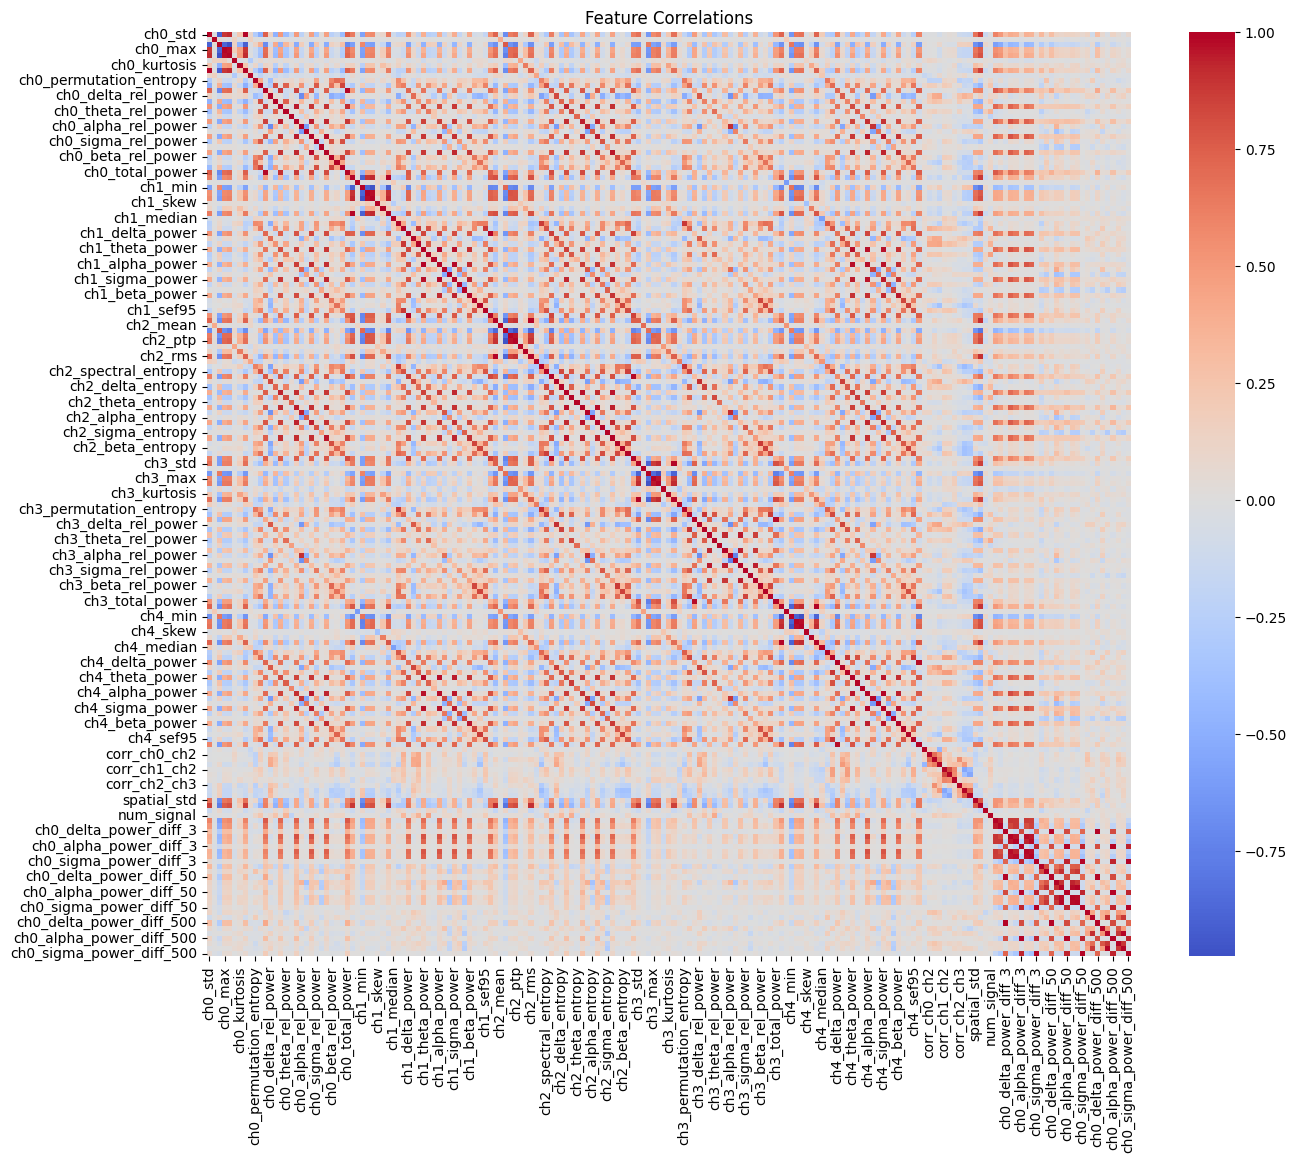

In [8]:
## Pas tres travaille pour l'instant, je voulais voir les correls et enlever ce qui est trop correle mais dure de faire de la feature selection

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations')
plt.show()

# Find highly correlated pairs (> 0.8 or <-0.8)
threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

## Build Model

### XGBoost models

In [26]:
# XGboost model train

X_df, y = df_features.drop(['num_signal', 'num_epoch'], axis=1), df['target'].astype(int)

# print(X_df.columns.to_list())


# 1. Split 
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=12)


# 2. Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=12
)

model.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model.predict(X_test)

f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_per_class = f1_score(y_test, predictions, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")

F1 Score (macro): 0.8646
F1 Score (micro): 0.9112
Class 0 F1 Score: 0.9083
Class 1 F1 Score: 0.5907
Class 2 F1 Score: 0.9341
Class 3 F1 Score: 0.9495
Class 4 F1 Score: 0.9404


In [16]:
y.unique()

array([0, 1, 2, 4, 3], dtype=object)

In [10]:
## Create submission, so we use whole dataset for training

X_df, y = df_features.drop(['num_signal'], axis=1), df['target']
df_test = format_data(False)
X_test = create_features_parallel(df_test).drop(['num_signal'], axis=1)


# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test = scaler.transform(X_test)



# Model that performed best for now
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)



model.fit(X_train, y.astype(int))
predictions = model.predict(X_test)


create_submission(df_test, predictions, "less_param")

Processing 4077 epochs in parallel...
Adding temporal context...


C:\Users\Adrien\AppData\Local\Temp\ipykernel_22532\2620266625.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_22532\2620266625.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_22532\2620266625.py:150: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
# Create a submission for simple random forest
## This showed us that all the models perform similarly, so we need one more good feature probably to be well ranked in the leaderbord

rf = RandomForestClassifier(
    max_depth=15, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)


rf.fit(X_train, y.astype(int))
predictions = rf.predict(X_test)

create_submission(df_test, predictions, 'rf_')

labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
## Same for SVM that performs similarly to the other models
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM with custom class weights
svm = SVC(
    kernel='rbf',  # or 'linear', 'poly'
    C=1.0,
    gamma='scale',
    class_weight={0: 1, 1: 6, 2: 1, 3: 1, 4: 1},  # Boost class 1
    random_state=42,
    probability=False  # Enable if you need predict_proba
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"\nTest Set Results:")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print("\nPer-class F1 Scores:")
for class_idx, score in enumerate(f1_per_class):
    print(f"  Class {class_idx}: {score:.4f}")


Test Set Results:
F1 Macro: 0.8279
F1 Weighted: 0.8745

Per-class F1 Scores:
  Class 0: 0.8720
  Class 1: 0.5442
  Class 2: 0.9062
  Class 3: 0.9346
  Class 4: 0.8824
